# Vehicle Detection Project

This project uses Yolov3 model to detect vechicles by keras.

## Import Packages

In [1]:
import io
import os
from collections import defaultdict
import colorsys
import random
import matplotlib.image as mpimg
import cv2
import numpy as np
import glob
import time

from keras.models import Model
from keras.utils.vis_utils import plot_model as plot
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Function

### intersection-over-union Calculation

![](resources/interval.jpg)

In [2]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

In [3]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3   

def converxywh_to_xycoord(box):
    """
    conver box centerx,y box width,height to x_min,x_max,y_min,y_max
    
    """
    x, y, w, h = box[:4]
    x_min,x_max,y_min,y_max = x - w/2.0,x + w/2.0,y - h/2.0,y + h/2.0
    
    return x_min,x_max,y_min,y_max

def area(box):
    """
    box region area
    
    """
    x, y, w, h = box[:4]
    return (w*h)
    

def box_iou(box1,box2):
    """
    intersection-over-union Calculation used by nms filter
    
    """
    x1_min,x1_max,y1_min,y1_max = converxywh_to_xycoord(box1)
    x2_min,x2_max,y2_min,y2_max = converxywh_to_xycoord(box2)
    
    intersect_w = _interval_overlap([x1_min,x1_max], [x2_min, x2_max])
    intersect_h = _interval_overlap([y1_min, y1_max], [y2_min, y2_max])
    
    intersect = intersect_w * intersect_h
    
    union = area(box1) + area(box2)- intersect
    
    return float(intersect) / union

### Decode network out

The feature map of yolo ouput can be divided into (grid_w,grid_h,nb_box,4.cood+1.confidence+classes).


![](resources/network_output.jpg)

### Bounding boxes with dimension priors and location prediction

![](resources/boundingbox.jpg)

In [4]:
def decode_netout(networkouput, anchors, nb_class, obj_threshold = 0.1,nms_threshold = 0.3):
    """
    decode network ouput to predict bounding box
    
    """
    netout = networkouput.copy()
    
    grid_h, grid_w, nb_box = netout.shape[:3]
    
    boxes = []
     
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _sigmoid(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold

    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]
                
                    x = (col + _sigmoid(x)+1) / grid_w # center position, unit: image width +1:to just output why??
                    y = (row + _sigmoid(y)+1) / grid_h # center position, unit: image height
                    w = anchors[b,0] * np.exp(w) / 416 # width accoding to network input shape in yolov3
                    h = anchors[b,1] * np.exp(h) / 416 # height accoding to network input shape in yolov3
                    confidence = netout[row,col,b,4]

                    classes = netout[row,col,b,5:]
                    boxes.append([x, y, w, h,confidence,classes])
                    
    return boxes

### NMS（non maximum suppression）

Non maximum suppression for Object Detection is to filter redundant bouding box sorted by every class.

In [5]:
def nms_filter(boxes, nb_class, obj_threshold = 0.1, nms_threshold = 0.3):
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box[5][c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i][5][c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]

                    if box_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j][5][c] = 0

    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box[5][(np.argmax(box[5:]))] > obj_threshold]
    
    return boxes   

In [6]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    
    
    random.seed(1010)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors) # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),colors))
    
    return colors

## YOLO Class

In [7]:
class YOLO(object):
    def __init__(self,model_path = 'model_data/yolo.h5',anchors_path = 'model_data/yolov3_anchors.txt',\
                 classes_path = 'model_data/coco_classes.txt',obj_threshold = 0.5, nms_threshold = 0.3):
        self.model_path = model_path
        self.anchors_path = anchors_path
        self.classes_path = classes_path
        self.obj_threshold = obj_threshold
        self.nms_threshold = nms_threshold
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
    
    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
            class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):   
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
            anchors = [float(x) for x in anchors.split(',')]
            anchors = np.array(anchors).reshape(-1, 2)
        return anchors

    def load_model(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model must be a .h5 file.'

        self.yolo_model = load_model(model_path)
        print('{} model, {} anchors, and {} classes loaded.'.format(model_path,len(self.anchors),len(self.class_names)))
        
        self.model_image_size = self.yolo_model.layers[0].input_shape[1:3]
        
        print('Model input size:{}.'.format(self.model_image_size))
    
    def detect_image(self, image):
        image_data = cv2.resize(image, self.model_image_size)
        image_data = image_data/255.0
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        all_predicts = self.yolo_model.predict(image_data)
        
        results = []

        # for predicts in allpredicts:
        for i,predicts in enumerate(all_predicts):

            predicts = all_predicts[i]
            res = np.reshape(predicts,(predicts.shape[1],predicts.shape[2],int(len(self.anchors)/3),5+len(self.class_names)))

            result = decode_netout(res,self.anchors[6-3*i:9-3*i],len(self.class_names),\
                                   self.obj_threshold,self.nms_threshold)

            results.extend(result)
        
        results = nms_filter(results, len(self.class_names), self.obj_threshold,self.nms_threshold)
            
        show_images = np.copy(image)
        colors = random_colors(len(self.class_names))
       
        for i,predits in enumerate(results):
            x, y, w, h,confidence,classone = predits
            classone = np.argmax(classone)

            #coordinate converation
            x = x *  self.model_image_size[1] * (image.shape[1] / self.model_image_size[1])
            y = y *   self.model_image_size[0] * (image.shape[0] / self.model_image_size[0])
            w = w *   self.model_image_size[1] * (image.shape[1] / self.model_image_size[1])
            h = h *  self.model_image_size[0] * (image.shape[0] / self.model_image_size[0])

            xmin = int(x - w/2.0)
            xmax = int(x + w/2.0)
            ymin = int(y - h/2.0)
            ymax = int(y + h/2.0)

            color = colors[int(classone)]
            label = '{}:{:.1f}%'.format(self.class_names[classone],confidence*100)

            cv2.rectangle(show_images,(xmin,ymin),(xmax,ymax),color, 3)
            cv2.putText(show_images,label,(xmin,ymin-10),cv2.FONT_HERSHEY_COMPLEX,1,color,2)
            
        return show_images

    def detect_video(self, video_source):

        cap = cv2.VideoCapture(video_source)

        count = 0

        while True:
            ret, frame = cap.read()
            if ret == True:
                start = time.time()

                vechilefinds = self.detect_image(frame)

                done = time.time()
                elapsed = done - start
                if elapsed !=0:
                    fps = 1.0/elapsed
                frame_label = 'Fps:{:.1f}'.format(fps)

                cv2.putText(vechilefinds,frame_label,(0, 30),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),1)

                cv2.imshow('video', vechilefinds)
            else:
                break

            if cv2.waitKey(1) & 0xff == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows() 

## YOLO Class Load

In [8]:
md = YOLO()
md.load_model()

model_data/yolo.h5 model, 9 anchors, and 80 classes loaded.
Model input size:(416, 416).


d:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Test Images

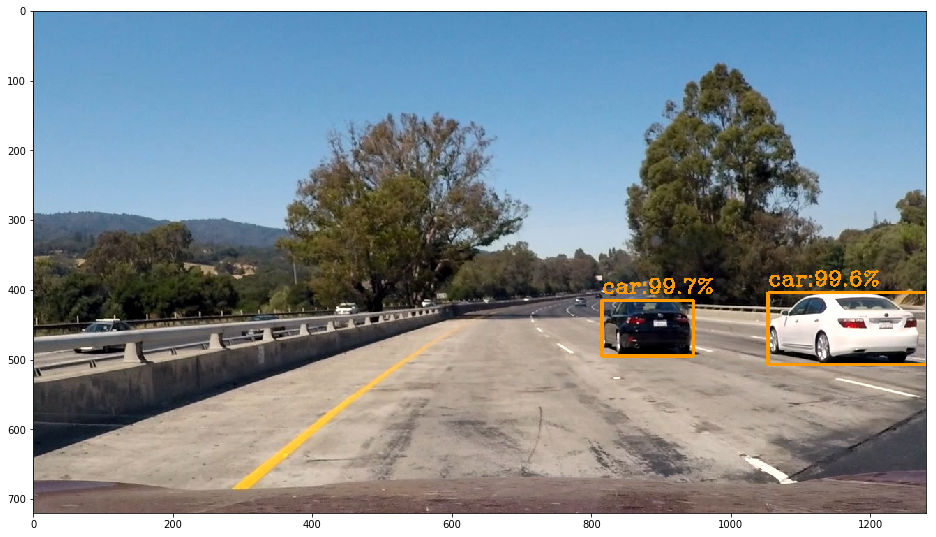

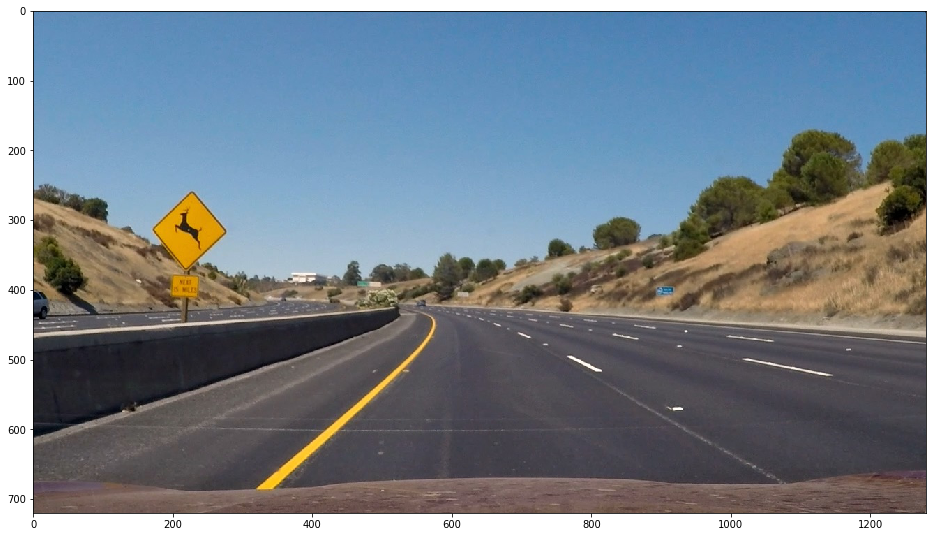

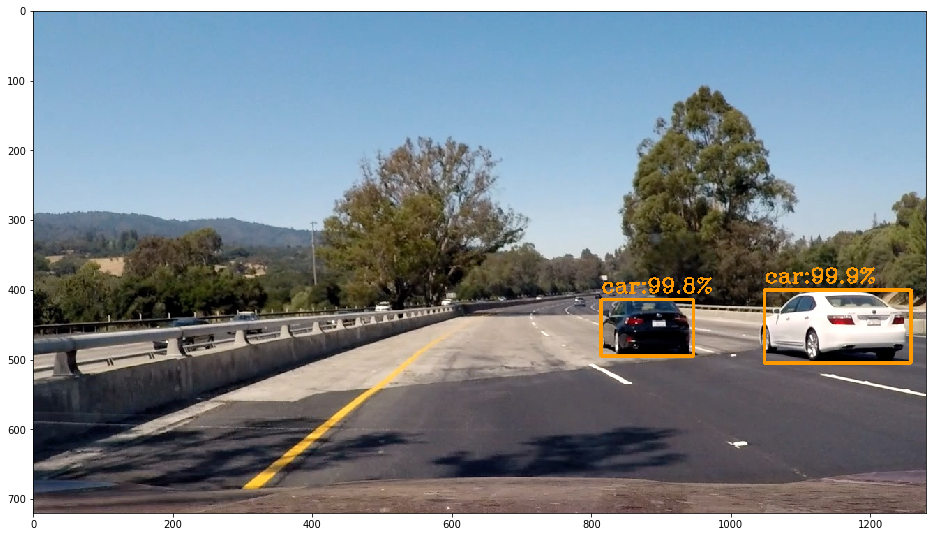

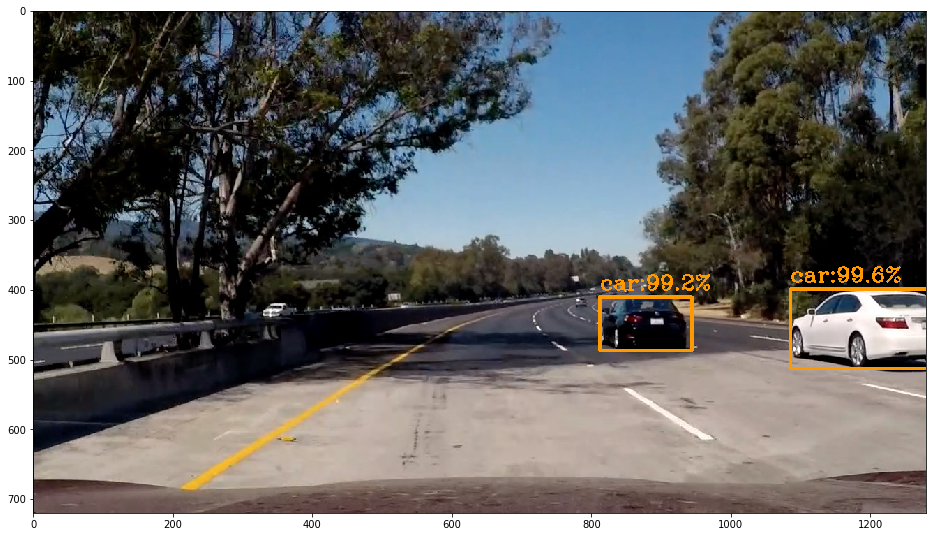

In [9]:
test_images = [plt.imread(path) for path in glob.glob('test_images/test*.jpg')]

for i, image in enumerate(test_images):
    vechilefinds = md.detect_image(image)

    fig = plt.figure(figsize=(16, 16))
    plt.imshow(vechilefinds)

## Test Video

In [ ]:
video_source = "test_videos/project_video.mp4"
md.detect_video(video_source)

## Video detection

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_source = "test_videos/project_video.mp4"
project_output = "test_videos_output/project_video_output.mp4"


## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# L = Vechiledectect()

clip1 = VideoFileClip(project_source)
line_clip = clip1.fl_image(md.detect_image) #NOTE: this function expects color images!!
%time line_clip.write_videofile(project_output, audio=False)

In [ ]:
HTML("""
<video width="1080" height="640" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
line_clip.resize(height=360).speedx(5).to_gif('resources/project.gif')

![](resources/project.gif)